In [4]:
import numpy as np
import math
from sklearn.metrics import mean_squared_error

In [14]:
def shuffle_data(X, y, seed=None):
    "shuffle X and y"
    if seed:
        np.random.seed(seed)
    idx = np.arange(X.shape[0])
    print(type(idx))
    np.random.shuffle(idx)
    return X[idx], y[idx]

In [29]:
def train_test_split(X, y, test_size=0.5,shuffle=True,seed=None):
    if shuffle:
        X,y = shuffle_data(X,y,seed)
    split_i=len(y)-int(len(y)//(1/test_size))
    X_train, X_test = X[:split_i], X[split_i:]
    y_train, y_test = y[:split_i], y[split_i:]
    return X_train, X_test, y_train, y_test

In [61]:
from sklearn.datasets import make_regression
import matplotlib.pylab as plt

X, y = make_regression(n_samples=100, n_features=1, noise=20)

X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2)

s = sorted([(X_test[i][0], y_test[i]) for i in range(len(X_test))], key=lambda j:j[0])

<class 'numpy.ndarray'>


In [38]:
X_test = np.array([[j[0]] for j in s])
y_test = np.array([j[1] for j in s])

方差: 465.07269699757944


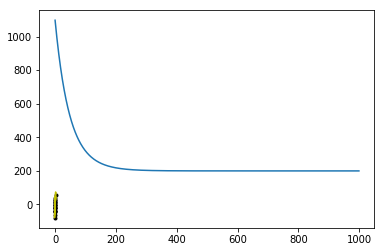

In [84]:
class Regression(object):
    
    def __init__(self, n_iterations, learning_rate):
        self.n_iterations = n_iterations
        self.learning_rate = learning_rate
        self.regularization = lambda x:0
        self.regularization.grad = lambda x:0
    
    def initialize_weights(self, n_features):
        """
        初始化洗漱，输入是feature的个数， 输出是一个随机初始化好的参数矩阵,[-1/N,1/N]
        """
        limit=1/math.sqrt(n_features)
        self.w=np.random.uniform(-limit,limit,(n_features,))
    
    def fit(self, X, y):
        #插入偏置列1到X中
        X = np.insert(X,0,1,axis=1)#给每一行的第0列增加一个1
        self.training_erros=[]
        self.initialize_weights(n_features=X.shape[1])#初始化参数w
        
        for i in range(self.n_iterations):
            y_pred = X.dot(self.w)
            #print(self.training_erros)
            mse = np.mean(0.5*(y-y_pred)**2+self.regularization(self.w))
            self.training_erros.append(mse)# 将loss加入到trainning_erros的数组中
            #计算带有正则化的梯度
            g_w = -(y-y_pred).T.dot(X)/len(X)+self.regularization.grad(self.w)
            self.w -= self.learning_rate*g_w
    
    def predict(self, X):
        # 通过输入X预测一个样本
        X = np.insert(X,0,1,axis=1)
        pred = X.dot(self.w)
        return pred

model = Regression(n_iterations=1000, learning_rate=0.01)
model.fit(X_train, y_train)

trainning, = plt.plot(range(len(model.training_erros)), model.training_erros, label="Trainning Erros")
test_and_draw(model)

## 带有最小二乘法的线性回归

In [68]:
def lsm_function(X,y):
    G = np.mat(np.insert(X,0,1,axis=1))
    return np.squeeze(np.asarray((G.T.dot(G).I.dot(G.T).dot(y))))

In [69]:
lsm_function(X_train,y_train)

array([-4.05587342, 41.79792223])

In [79]:
class LinearRegression(Regression):
    def __init__(self, n_iterations=500, learning_rate=0.1, gradient_descent=True):
        self.gradient_descent = gradient_descent
        self.regularization = lambda x:0
        self.regularization.grad = lambda x: 0
        super(LinearRegression,self).__init__(n_iterations=n_iterations,learning_rate=learning_rate)
    
    def fit(self,X,y):
        if not self.gradient_descent:
            self.w=lsm_function(X, y)
        else:
            super(LinearRegression, self).fit(X, y)
    
    def predict(self, X):
        return super(LinearRegression, self).predict(X)

In [81]:
model = LinearRegression(n_iterations=1000, learning_rate=0.1, gradient_descent=False)
model.fit(X_train, y_train)
model.w

array([-4.05587342, 41.79792223])

方差: 465.13669450819526


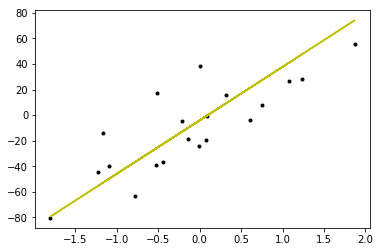

In [83]:
def test_and_draw(model):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print("方差:", mse)
    plt.plot(X_test, y_test, 'k.')
    plt.plot(X_test, y_pred, 'Y')
test_and_draw(model)

## 正则化回归 

In [94]:
class l1_regularization():
    
    def __init__(self, alpha):
        self.alpha=alpha
    def __call__(self, w):
        return self.alpha*np.linalg.norm(w,ord=1)
    def grad(self, w):
        #w>0->w'=1, w=0->w'=0, w<0->w'=-1
        return self.alpha*np.sign(w)
    
l1 = l1_regularization(alpha=.01)
print(l1([-3, 4]))
print(l1.grad([-3,4,0]))

0.07
[-0.01  0.01  0.  ]


In [95]:
class l2_regularization():
    """
    参数：alpha 正则化参数
    """
    def __init__(self, alpha):
        self.alpha = alpha
    def __call__(self, w):
        return self.alpha*0.5*w.T.dot(w)
    def grad(self,w):
        return self.alpha*w

In [98]:
class LassoLinearRegression(Regression):
    def __init__(self, alpha, n_iterations=1000, learning_rate=0.01):
        self.regularization=l1_regularization(alpha=alpha)
        super(LassoLinearRegression, self).__init__(n_iterations, learning_rate)
    
    def fit(self, X,y):
        super(LassoLinearRegression, self).fit(X,y)
    
    def predict(self, X):
        return super(LassoLinearRegression, self).predict(X)

In [100]:
model = LassoLinearRegression(alpha=1.2, n_iterations=1000, learning_rate=0.1)
model.fit(X_train, y_train)

In [101]:
model.w

array([-4.05587342, 41.79792223])

方差: 465.1366945081947


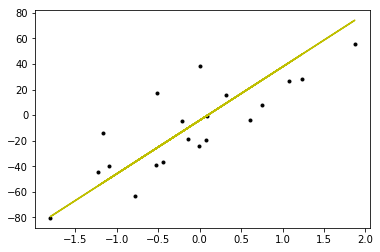

In [102]:
test_and_draw(model)